In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pycirclize import Circos
from scipy.sparse import csr_matrix
import networkx as nx
import time

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import plotting as plt2
import hypercore as hc
import matrix as matrix
import utils as ut
import centrality as central

# Load chromsizes

In [2]:
resolution = 1e5
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/reference/chrom_sizes.csv"
chrom = pd.read_csv(fpath)
chrom['n_bins'] = (chrom['size'] // resolution).astype(int)
chrom['global_bin_start'] = (chrom['bp_start'] // resolution).astype(int)
chrom['global_bin_end'] = ((chrom['bp_start'] + chrom['size']) // resolution).astype(int)

chrom_starts = dict(zip(chrom['chrom'].values, chrom['bp_start'].values))

chrom.head()

,chrom,size,bp_start,n_bins,global_bin_start,global_bin_end
0,1,195154279,0,1951,0,1951
1,2,181755017,195154279,1817,1951,3769
2,3,159745316,376909296,1597,3769,5366
3,4,156860686,536654612,1568,5366,6935
4,5,151758149,693515298,1517,6935,8452


In [3]:
def apply_get_chrom(row):
    mask = (row['global_bin'] <= chrom['global_bin_end']) & (row['global_bin'] >= chrom['global_bin_start'])
    if mask.any():
        return chrom[mask]['chrom'].values[0]
    
    
binmap = pd.DataFrame({
  'global_bin' :  range(chrom['global_bin_end'].max() + 1)
})

binmap['chrom'] = binmap.apply(apply_get_chrom, axis=1)
binmap['local_bin'] = binmap.groupby('chrom').cumcount() 

# define the maps
local_2_global = dict(zip(binmap['local_bin'].values, binmap['global_bin'].values))
global_2_local = dict(zip(binmap['global_bin'].values, binmap['local_bin'].values))

binmap.head()

,global_bin,chrom,local_bin
0,0,1,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


# Load Data

In [4]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/pore_c/population_mESC.read_level.parquet"

start_time = time.time()  # Start the timer
df = pd.read_parquet(fpath)
load_time = time.time() - start_time  # Calculate loading time
print(f"Data loading time: {load_time:.2f} seconds")
print(f"Raw data shape: {df.shape}")

df['global_bin'] = (df['global_position'] // resolution).astype(int)
df['read_id'] = pd.factorize(df['read_name'])[0]
df = df.drop_duplicates(subset=['read_id', 'global_bin'])
df['binned_order'] = df.groupby('read_id')['global_bin'].transform('nunique')

# drop low-order hyperedges based on the resolution
df = df[df['binned_order'] > 2]

# Use formatted strings for clearer output
print(f"Filtered data shape: {df.shape}")
print(f"Number of unique read IDs: {df['read_id'].nunique()}")
print(f"Number of unique global bins: {df['global_bin'].nunique()}")

df['val'] = 1
# Display the first few rows
print(df.head().to_string(index=False))  # Suppress the index for cleaner output

Data loading time: 5.17 seconds
Raw data shape: (14810238, 8)
Filtered data shape: (9091057, 11)
Number of unique read IDs: 1784705
Number of unique global bins: 25683
                           read_name chrom  ref_start  ref_end basename  local_position  global_position  order  global_bin  read_id  binned_order  val
00001eac-9561-4bd2-a272-1b0a475d75e5    13   21752768 21753106  batch04        21752937       1788694006      6       17886        2             3    1
00001eac-9561-4bd2-a272-1b0a475d75e5    13    9587846  9588362  batch04         9588104       1776529173      6       17765        2             3    1
00001eac-9561-4bd2-a272-1b0a475d75e5    13    3847827  3847900  batch04         3847863       1770788932      6       17707        2             3    1
00002cf2-3a39-4d41-b231-75b50a5df98a     5   54958588 54958907  batch04        54958747        748474045      4        7484        3             3    1
00002cf2-3a39-4d41-b231-75b50a5df98a     5   54733402 54733982  batch04 

# Pivot Data

In [5]:
def frame_to_sparse_matrix(df, row_col, col_col, data_col, shape):
    """Converts a DataFrame to a sparse CSR matrix based on specified columns.

    Args:
        df: The DataFrame to convert.
        row_col: The column representing row data.
        col_col: The column representing column data.
        count_col: The column representing count or value data.

    Returns:
        A sparse CSR matrix representing the pivoted table.
    """
    data = df[data_col].tolist()
    row = df[row_col].values
    col = df[col_col].values
    return csr_matrix((data, (row, col)), shape=shape)


start_time = time.time()  # Start the timer
H = frame_to_sparse_matrix(
    df, 
    'global_bin',
    'read_id',
    'val',
    (df['global_bin'].max() + 1, df['read_id'].max() + 1)
)
load_time = time.time() - start_time  # Calculate loading time

print(f"Full pivot took {load_time:.2f} seconds")
print(f"Data has shape: {H.shape}")

Full pivot took 1.67 seconds
Data has shape: (26319, 2755830)


In [6]:
read_id = np.random.choice(df['read_id'], 1)[0]

print(np.nonzero(H[:, read_id])[0])
print()

test = df[df['read_id'] == read_id]
test

[ 1506  5920 14487 15571 20946 24526 26168]



,read_name,chrom,ref_start,ref_end,basename,local_position,global_position,order,global_bin,read_id,binned_order,val
7356751,44c6b350-4542-4f18-826d-c28150c8f48a,19,51629557,51630016,batch03,51629786,2452692067,11,24526,1344157,7,1
7356752,44c6b350-4542-4f18-826d-c28150c8f48a,10,54421918,54421997,batch03,54421957,1448766038,11,14487,1344157,7,1
7356757,44c6b350-4542-4f18-826d-c28150c8f48a,X,154327596,154327849,batch03,154327722,2616810007,11,26168,1344157,7,1
7356758,44c6b350-4542-4f18-826d-c28150c8f48a,15,81698674,81698891,batch03,81698782,2094662682,11,20946,1344157,7,1
7356759,44c6b350-4542-4f18-826d-c28150c8f48a,4,55438995,55439123,batch03,55439059,592093671,11,5920,1344157,7,1
7356760,44c6b350-4542-4f18-826d-c28150c8f48a,1,150617295,150617986,batch03,150617640,150617640,11,1506,1344157,7,1
7356761,44c6b350-4542-4f18-826d-c28150c8f48a,11,32321896,32321993,batch03,32321944,1557196887,11,15571,1344157,7,1


# Centrality

In [7]:
# Calculate centrality
start_time = time.time()  # Start the timer
nodes_cent, edges_cent = central.nonlinear_eigenvector_centrality(
    H, 
    function='log-exp', 
    maxiter=10000,
)
load_time = time.time() - start_time  # Calculate loading time
print(f"Centrality took {load_time:.2f} seconds")
print(f"Data has shape: {nodes_cent.shape}")

Centrality took 114.11 seconds
Data has shape: (26319,)


# Centrality Summary

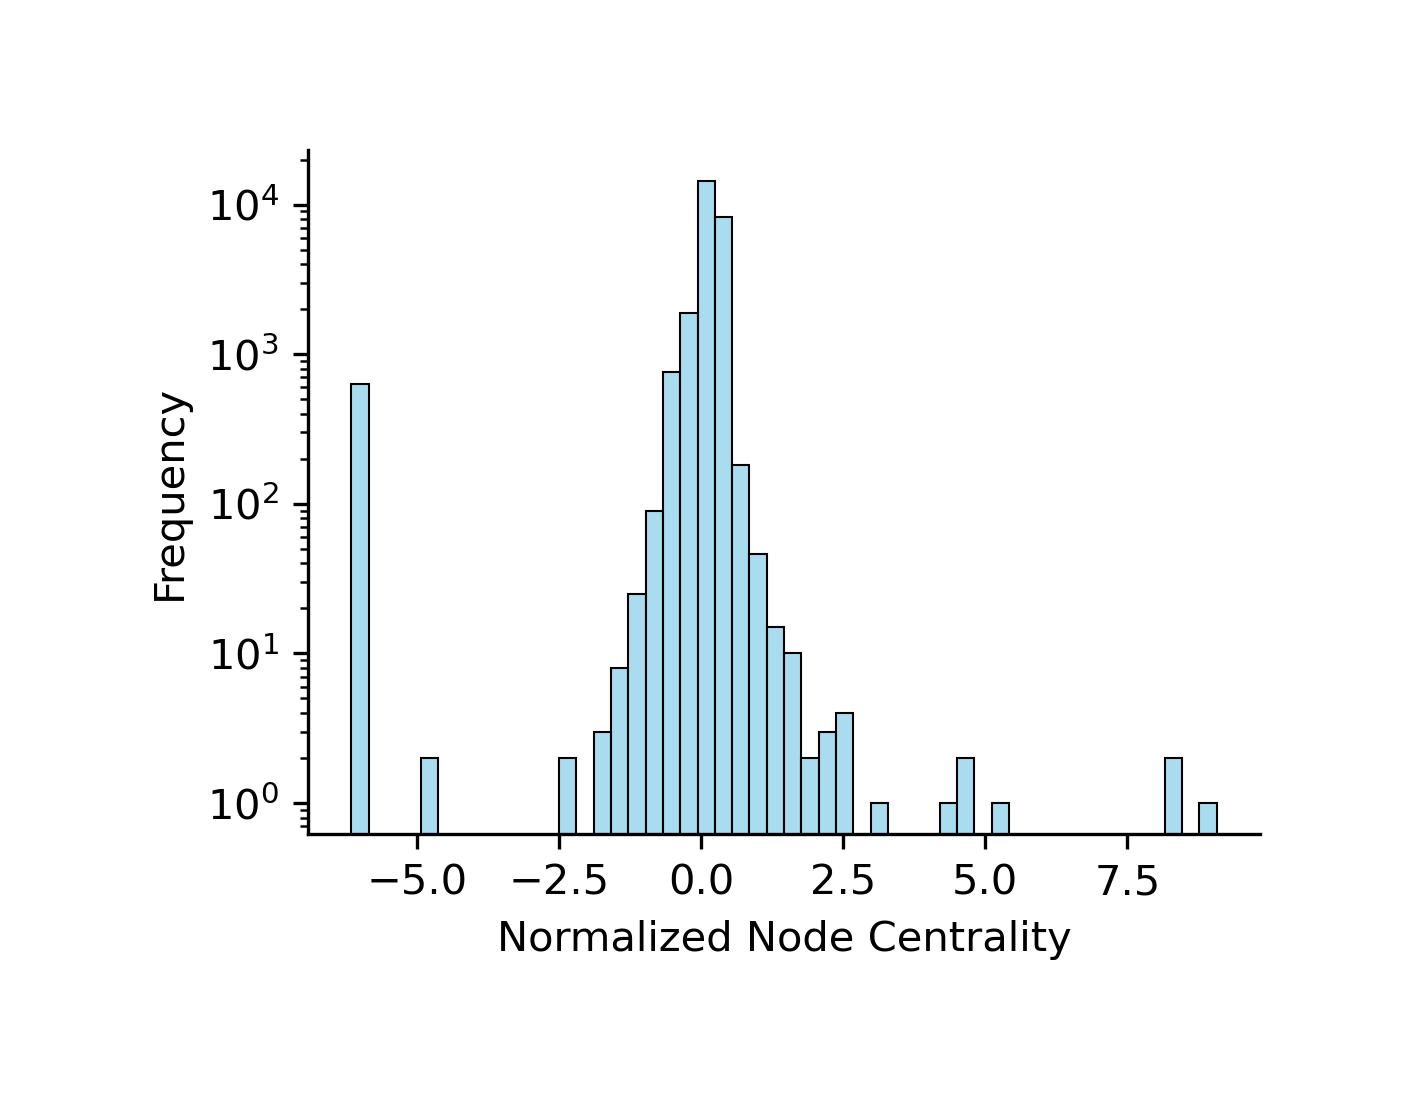

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    data=scipy.stats.zscore(nodes_cent), 
    bins=50, 
    color="skyblue", 
    alpha=0.7, 
    edgecolor="black", 
    linewidth=0.5,
)

plt.yscale('log')

plt.xlabel("Normalized Node Centrality")
plt.ylabel("Frequency")
sns.despine()
plt.tight_layout()

In [9]:
nodes = pd.DataFrame({
    'global_bin' : list(range(df['global_bin'].max() + 1)), 
    'value' : nodes_cent,
    'normed_value' : scipy.stats.zscore(nodes_cent),
})

# # Apply the mapping function to create the new column
nodes['chrom'] = nodes.apply(apply_get_chrom, axis=1)
nodes.head()

,global_bin,value,normed_value,chrom
0,0,0.0,-6.153438,1
1,1,0.0,-6.153438,1
2,2,0.0,-6.153438,1
3,3,0.0,-6.153438,1
4,4,0.0,-6.153438,1


Text(0, 0.5, 'Max Node Centrality')

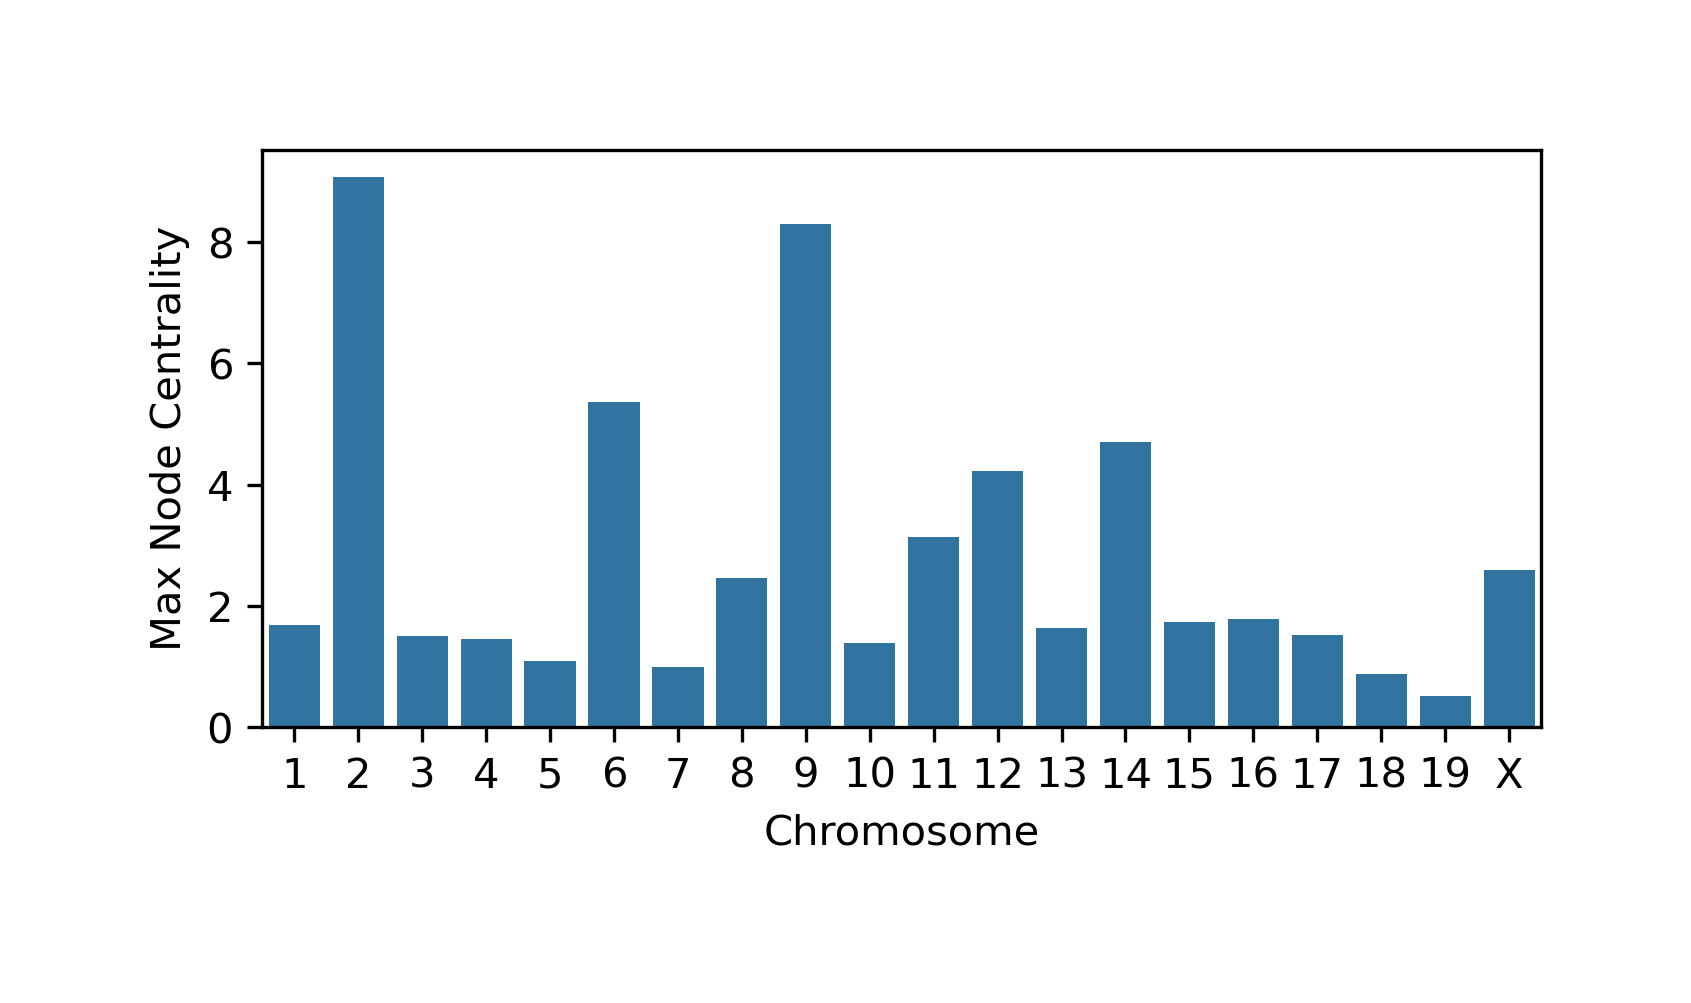

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5.5, 2.5

sns.barplot(
    nodes,
    x='chrom',
    y='normed_value',
    ec='k',
    estimator=np.max,
    errorbar=None,
)

plt.xlabel('Chromosome')
plt.ylabel('Max Node Centrality')

In [11]:
fpath = "../resources/mESC_pangloadb.csv"
pang = pd.read_csv(fpath)
pang.head()

,gene_name,cell_type,ubiquitousness,sensitivity_mouse,specificity_mouse
0,MYC,Embryonic stem cells,0.047,0.000000,0.033132
1,FOXD3,Embryonic stem cells,0.000,0.000000,0.000449
2,POU5F1,Embryonic stem cells,0.003,0.909091,0.001926
3,FUT4,Embryonic stem cells,0.001,0.000000,0.000706
4,ITGA4,Embryonic stem cells,0.036,0.000000,0.041287


gdf.shape=(21441, 10)


Text(0, 0.5, 'mESC Genes')

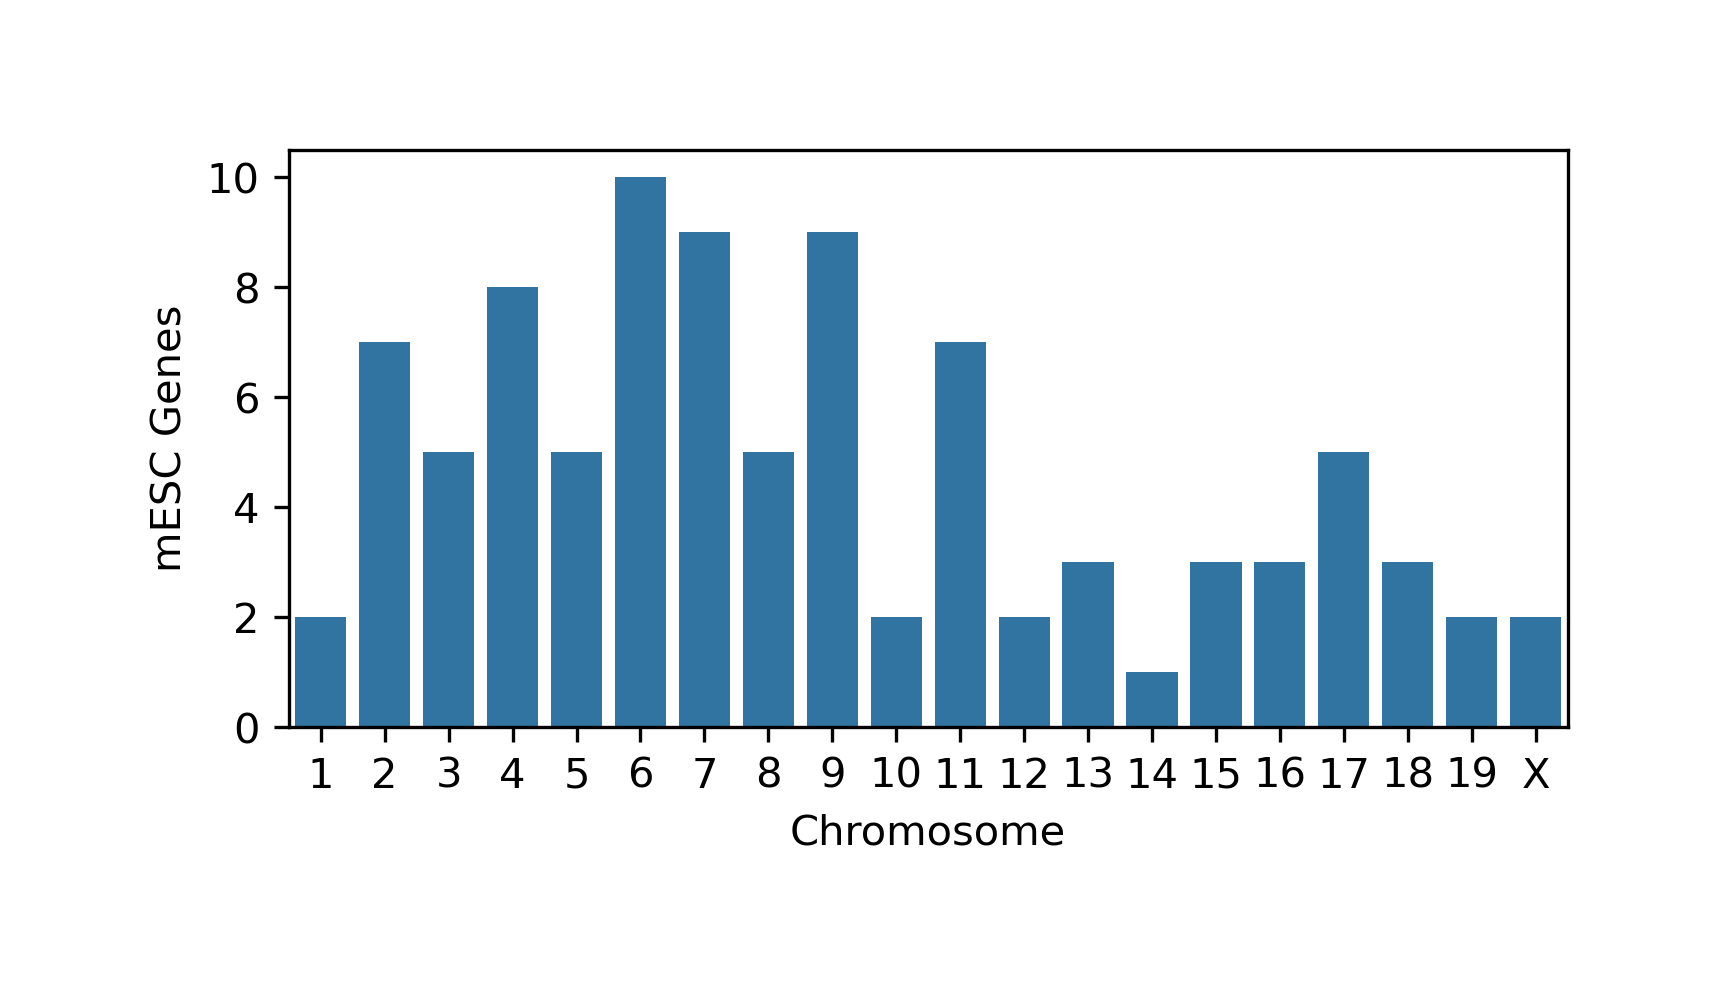

In [12]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/reference/gene_table.parquet"
gdf = pd.read_parquet(fpath)

gdf = gdf[gdf['gene_biotype'] == 'protein_coding']
gdf = gdf[gdf['Chromosome'].isin(chrom['chrom'].values)]
print(f"{gdf.shape=}")

gdf['gene_name'] = gdf['gene_name'].str.upper()
gdf['is_mouse'] = gdf['gene_name'].isin(pang['gene_name'].values)

gdf['chrom_start'] = gdf['Chromosome'].map(chrom_starts)
gdf['global_position'] = gdf['midpoint'] + gdf['chrom_start']
gdf['global_bin'] = (gdf['global_position'] // resolution).astype(int)
gdf['local_bin'] = (gdf['midpoint'] // resolution).astype(int)

gdf_gx = gdf.groupby('Chromosome', sort=False)['is_mouse'].sum()
gdf_gx = gdf_gx.reset_index()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5.5, 2.5

sns.barplot(
    gdf_gx,
    x='Chromosome',
    y='is_mouse',
    ec='k',
)

plt.xlabel('Chromosome')
plt.ylabel('mESC Genes')



# How direct is the relationship?

In [13]:
gdf = pd.merge(
    gdf,nodes,
    how='left'
)

gdf.head()

,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf,is_mouse,chrom_start,global_position,global_bin,local_bin,value,normed_value,chrom
0,ENSMUSG00000051285,PCMTD1,ensembl_havana,protein_coding,1,7159143,7243852,84709,7201497,False,False,0,7201497,72,72,0.000040,0.307223,1
1,ENSMUSG00000026312,CDH7,ensembl_havana,protein_coding,1,109910160,110067887,157727,109989023,False,False,0,109989023,1099,1099,0.000038,-0.011197,1
2,ENSMUSG00000039748,EXO1,ensembl_havana,protein_coding,1,175708146,175741055,32909,175724600,False,False,0,175724600,1757,1757,0.000039,0.119344,1
3,ENSMUSG00000104158,BECN2,havana,protein_coding,1,175747894,175749791,1897,175748842,False,False,0,175748842,1757,1757,0.000039,0.119344,1
4,ENSMUSG00000033007,ASIC4,ensembl_havana,protein_coding,1,75427079,75450987,23908,75439033,False,False,0,75439033,754,754,0.000039,0.235560,1


In [14]:
# chromosome = "10"

# start_idx = chrom.loc[chrom['chrom'] == chromosome]['global_bin_start'].values[0]
# end_idx = chrom.loc[chrom['chrom'] == chromosome]['global_bin_end'].values[0]

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 3

# sns.lineplot(
#     nodes_cent[start_idx:end_idx],   
# )

# plt.xlabel(f"Chromosome {chromosome} Loci (1Mb)")

# The Core

core_edges.shape=(1590, 25)


,2936,12729,12730,9488,13052,18908,16500,15280,26047,11609,...,11604,21201,11600,21125,11598,246,18252,22552,22181,3799
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


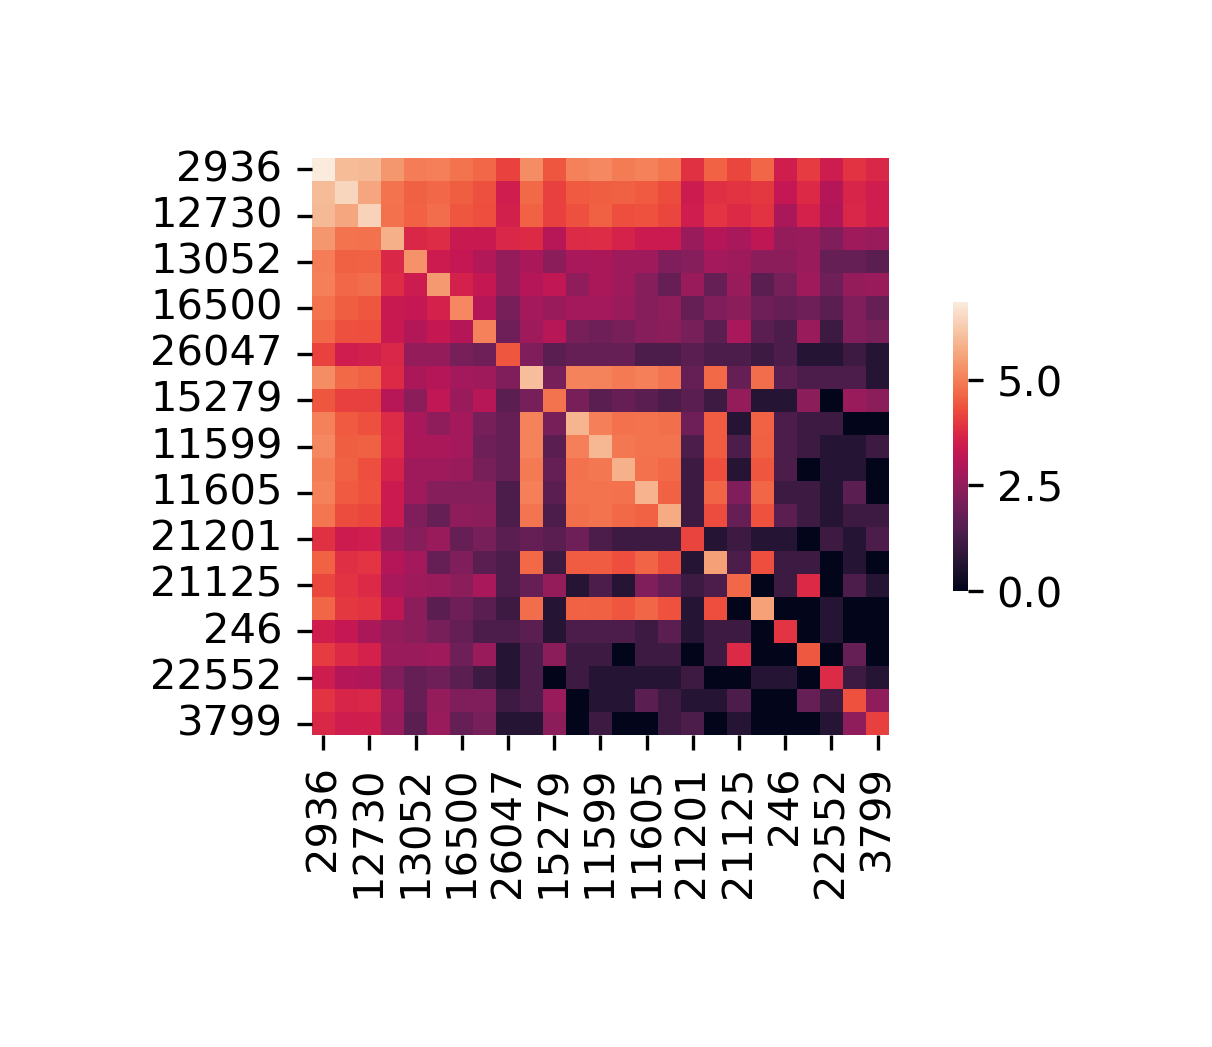

In [15]:
top_bins = 25

nodes = nodes.sort_values(by='normed_value', ascending=False)
bins = nodes['global_bin'].head(top_bins).values

core_edges = H[bins, :]
edge_mask = core_edges.sum(axis=0) > 2
core_edges = core_edges[:, np.ravel(edge_mask)]

core_edges = pd.DataFrame(
    core_edges.todense().T,
    columns=list(bins),
)
core_edges = core_edges.drop_duplicates()

A = np.dot(core_edges.to_numpy().T, core_edges.to_numpy())
A = pd.DataFrame(
    A, 
    columns=list(bins),
    index=list(bins),
)

sns.heatmap(
    np.log1p(A),
    square=True,
    cbar_kws={'shrink' : 0.5,},
    # lw=0.5,
)

print(f"{core_edges.shape=}")
core_edges.head()

In [16]:
genes = gdf[gdf['global_bin'].isin(bins)]['gene_name'].to_list()
# [print(x) for x in genes]

([], [])

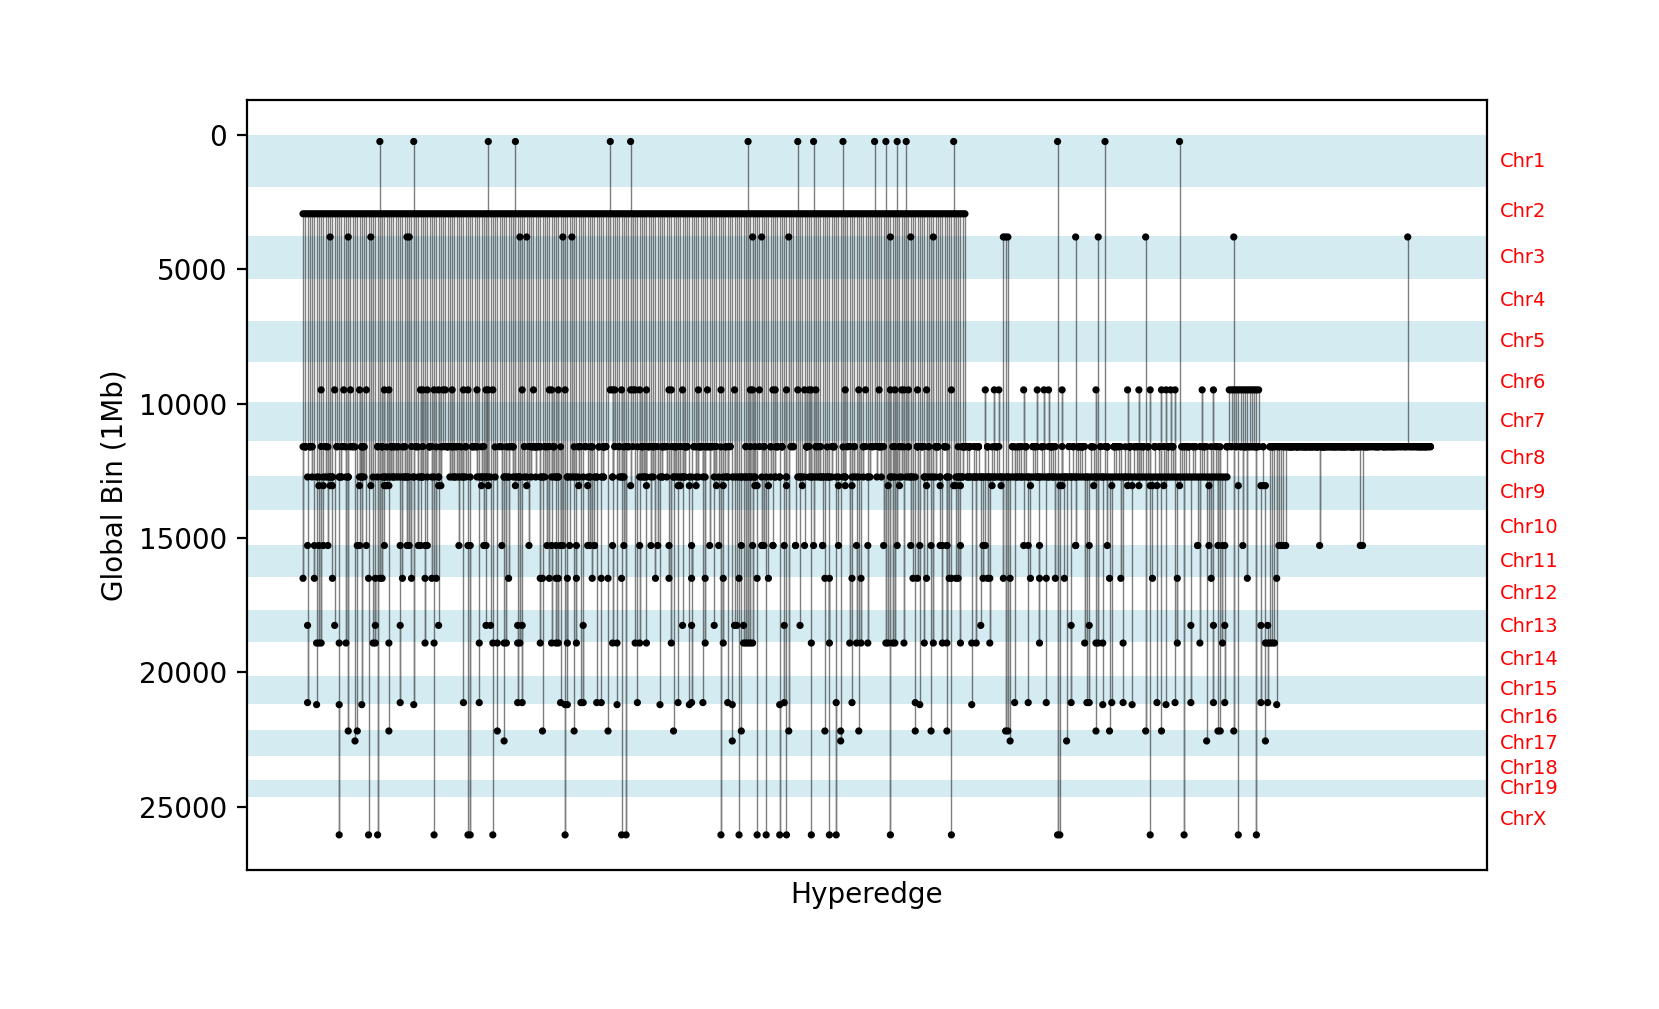

In [17]:
node_params = {
    's' : 10,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.5,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(core_edges.T.sample(sample_size, axis=1)), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)


plot_chrom = True
for _, row in chrom.iterrows():
    
    chrom_mid = ((row['global_bin_end'] - row['global_bin_start']) / 2) + row['global_bin_start']

    plt.text(
        sample_size+30, 
        chrom_mid, 
        f"Chr{row['chrom']}",
        size=7,
        ha='left',
        va='center',
        c='r',
    )
    
    if plot_chrom:
        plt.axhspan(
            row['global_bin_start'], 
            row['global_bin_end'],
            color='lightblue',
            alpha=0.5,
            zorder=0,
        )
        
    plot_chrom = not plot_chrom
    
plt.ylabel("Global Bin (1Mb)")
plt.xlabel("Hyperedge")
plt.xticks([])

# CIRCOS

In [18]:
def get_color(value, max_value, min_value, cmap):
    # Normalize your value to the [0, 1] range if needed
    normalized_value = (value - min_value) / (max_value - min_value) 

    # Get the corresponding color from the colormap
    return cmap(normalized_value)

In [2]:
cmap = cm.get_cmap('binary')

sectors = dict(zip(chrom['chrom'].values, chrom['n_bins'].values))

colors = [
    "#E6194B",  # Red
    "#3CB44B",  # Green
    "#FFE119",  # Yellow
    "#4363D8",  # Blue
    "#F58231",  # Orange
    "#911EB4",  # Purple
    "#42D4F4",  # Cyan
    "#F032E6",  # Magenta
    "#BFEF45",  # Lime
    "#FABED4",  # Pink
    "#469990",  # Teal
    "#DCBEFF",  # Lavender
    "#9A6324",  # Brown
    "#FFFAC8",  # Beige
    "#800000",  # Maroon
    "#AAFFC3",  # Mint
    "#808000",  # Olive
    "#FFD8B1",  # Apricot
    "#000075",  # Navy
    "#A9A9A9",  # Grey
]

plt.rcParams['figure.dpi'] = 300

circos = Circos(sectors, space=5)
for sector in circos.sectors:
    bartrack = sector.add_track((75, 100))
    
    gdf_chr = gdf[gdf['Chromosome'] == str(sector.name)]
    gdf_chr = gdf_chr.groupby('local_bin')['gene_name'].count().reset_index()
    x = gdf_chr['local_bin'].values
    y = gdf_chr['gene_name'].values
    
    bartrack.axis(ec='none')
    bartrack.bar(x, y, width=0.8, color="k",)

    track = sector.add_track((64, 74))
    track.axis(fc=colors[sector.name], zorder=100000)
    track.text(sector.name, color="k", fontweight='bold')

    

# Plot links
for i in list(bins):
    for j in list(bins):    
        if i == j:
            continue
    
        val = np.log1p(A.loc[i, j]) 
        
        color_val = get_color(
            val, 
            np.log1p(np.max(A)),
            np.log1p(np.min(A)),
            cmap
        )
        
        c1 = nodes.loc[nodes['global_bin'] == i]['chrom'].values[0]
        c2 = nodes.loc[nodes['global_bin'] == j]['chrom'].values[0]
        
        p1 = global_2_local[i]
        p2 = global_2_local[j]
                
        circos.link((c1, p1, p1+1), (c2, p2, p2+1), 
                    color=color_val, lw=2, 
                    height_ratio=0.4,
                    alpha=0.25, zorder=val)          
        
    
fig = circos.plotfig(dpi=300)

NameError: name 'chrom' is not defined

In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
?circos.link

In [ ]:
break

In [ ]:
sns.barplot(
    data=nodes_cent[:200]
)

In [ ]:
break